# Supervised Learning
## Sentiment Analysis on Amazon.com Banned Book Reviews
## Logistic Regression

## Import Libraries
**First, we will import our libraries and bring in our cleaned Amazon banned book review dataset.**


In [1]:
# Basic libraries
import pandas as pd 
import numpy as np 
import copy
import re
import string

# NLTK & gensim & spacy libraries
import nltk
from nltk.stem.porter import PorterStemmer
import gensim
import spacy
import en_core_web_sm
from  spacy.lang.en.stop_words import STOP_WORDS
nlp = en_core_web_sm.load()
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

# Evaluation libraries
from sklearn import metrics
from sklearn.metrics import classification_report, make_scorer, precision_recall_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

# Viz libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
import scattertext
from plotly.offline import iplot
%matplotlib inline
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.text.correlation import WordCorrelationPlot

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
rand_state = 42

# Data libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

# Import functionas from other notebooks
from ipynb.fs.full.confusion_matrix_plot import make_confusion_matrix

# Clean & Pre-Process Data

In [2]:
raw_reviews = pd.read_csv('../data/scraped_amz_reviews.csv')

## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(384233, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384233 entries, 0 to 384232
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   product_name       384233 non-null  object
 1   title              384213 non-null  object
 2   body               384126 non-null  object
 3   rating             384233 non-null  object
 4   verified_purchase  384233 non-null  bool  
 5   review_date        384233 non-null  object
dtypes: bool(1), object(5)
memory usage: 15.0+ MB
None


In [3]:
raw_reviews.head()

,product_name,title,body,rating,verified_purchase,review_date
0,Ace Spades Faridah Abike Iyimide,"An Engrossing Page Turner About Race, Class an...","Granted, I've never been a fan of Gossip Girl ...",4.0 out of 5 stars,True,"June 6, 2021"
1,Ace Spades Faridah Abike Iyimide,An Interesting Debut,"“Hello, Niveus High. It’s me. Who am I? That’s...",4.0 out of 5 stars,True,"June 14, 2021"
2,Ace Spades Faridah Abike Iyimide,Wow,I ordered this book for my teenage daughter an...,5.0 out of 5 stars,True,"September 12, 2022"
3,Ace Spades Faridah Abike Iyimide,Definitely a YA novel,"Great plot, childish characterizations (althou...",4.0 out of 5 stars,True,"August 10, 2022"
4,Ace Spades Faridah Abike Iyimide,A most timely book.,This a very engrossing story. I was intrigued...,5.0 out of 5 stars,True,"July 5, 2021"


In [4]:
# Make a copy of the original dataframe
reviews = raw_reviews.copy()

## Dataset

**Description of columns in the file:**
* product_name - name of book + author
* title - title of book review
* body - text of the review
* rating - rating of the book review
* verified_purchase - did the reviewer buy the book or not?
* review_date - the date of the review

<a id="section-two"></a>
# Preprocessing and cleaning

**We got to do lot of preprocessing before sending the reviews to the model. Let's go step by step.**

## Check for Duplicates and NaNs
**Let's check for duplicated Amazon.com reviews.**

In [5]:
reviews = reviews.drop_duplicates(subset=['body'])

In [6]:
len(reviews)

362924

In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362924 entries, 0 to 384232
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   product_name       362924 non-null  object
 1   title              362915 non-null  object
 2   body               362923 non-null  object
 3   rating             362924 non-null  object
 4   verified_purchase  362924 non-null  bool  
 5   review_date        362924 non-null  object
dtypes: bool(1), object(5)
memory usage: 17.0+ MB


**We got null values in reviewer title and body. There are not that many missing values, so I will drop them for now.**

In [8]:
reviews['title'] = reviews['title'].dropna()
reviews['body'] = reviews['body'].dropna()

## Concatenating the review title and body
Let's combine Amazon banned book reviews' title and body column and drop the body and title columns.

In [9]:
reviews['reviews'] = reviews['title'] + " " + reviews['body']
reviews = reviews.drop(['title', 'body'], axis=1)
reviews.head()

,product_name,rating,verified_purchase,review_date,reviews
0,Ace Spades Faridah Abike Iyimide,4.0 out of 5 stars,True,"June 6, 2021","An Engrossing Page Turner About Race, Class an..."
1,Ace Spades Faridah Abike Iyimide,4.0 out of 5 stars,True,"June 14, 2021","An Interesting Debut “Hello, Niveus High. It’s..."
2,Ace Spades Faridah Abike Iyimide,5.0 out of 5 stars,True,"September 12, 2022",Wow I ordered this book for my teenage daughte...
3,Ace Spades Faridah Abike Iyimide,4.0 out of 5 stars,True,"August 10, 2022","Definitely a YA novel Great plot, childish cha..."
4,Ace Spades Faridah Abike Iyimide,5.0 out of 5 stars,True,"July 5, 2021",A most timely book. This a very engrossing sto...


## Cleaning Rating column

In [10]:
# Grab the rating string
reviews['rating'] = reviews['rating'].astype(str).str[:1]

# Drop reviews without ratings
reviews = reviews[reviews.rating != 'n']

# Cast rating as integer
reviews['rating'] = reviews['rating'].astype(int)

## Create a 'sentiment' column
**This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as a neutral sentiment.**

In [11]:
# Figuring out the distribution of categories
reviews['rating'].value_counts()

5    245318
4     60450
3     25776
1     18576
2     12804
Name: rating, dtype: int64

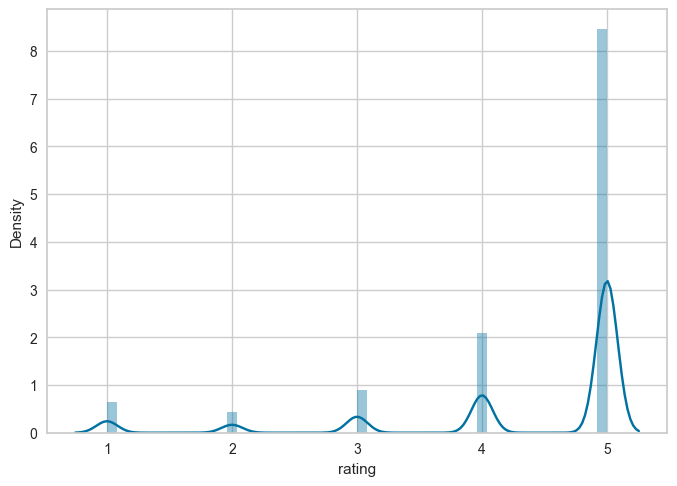

In [12]:
sns.distplot(reviews['rating']);

In [13]:
def sentiment(row):
    '''
    Returns the sentiment value based on the overall ratings from the reviewer.
    '''
    if row['rating'] == 4.0 or row['rating'] == 5.0:
        val = 'Positive'
    elif row['rating'] == 1.0 or row['rating'] == 2.0:
        val = 'Negative'
    elif row['rating'] == 3.0:
        val = 'Neutral'
    else:
        val = -1
    return val

In [14]:
# Applying the function in our new column
reviews['sentiment'] = reviews.apply(sentiment, axis=1)
reviews.head()

,product_name,rating,verified_purchase,review_date,reviews,sentiment
0,Ace Spades Faridah Abike Iyimide,4,True,"June 6, 2021","An Engrossing Page Turner About Race, Class an...",Positive
1,Ace Spades Faridah Abike Iyimide,4,True,"June 14, 2021","An Interesting Debut “Hello, Niveus High. It’s...",Positive
2,Ace Spades Faridah Abike Iyimide,5,True,"September 12, 2022",Wow I ordered this book for my teenage daughte...,Positive
3,Ace Spades Faridah Abike Iyimide,4,True,"August 10, 2022","Definitely a YA novel Great plot, childish cha...",Positive
4,Ace Spades Faridah Abike Iyimide,5,True,"July 5, 2021",A most timely book. This a very engrossing sto...,Positive


In [15]:
reviews['sentiment'].value_counts()

Positive    305768
Negative     31380
Neutral      25776
Name: sentiment, dtype: int64

In [16]:
reviews['sentiment'].value_counts(normalize=True)

Positive    0.842512
Negative    0.086464
Neutral     0.071023
Name: sentiment, dtype: float64

# More Text Cleaning
**Let's begin our text processing by removing the punctuations**

In [17]:
# Copy
clean_reviews = reviews.copy()

In [18]:
def clean_reviews(text):
    '''
    Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [19]:
reviews['reviews'] = reviews['reviews'].apply(lambda x: clean_reviews(x))
reviews.head()

,product_name,rating,verified_purchase,review_date,reviews,sentiment
0,Ace Spades Faridah Abike Iyimide,4,True,"June 6, 2021",an engrossing page turner about race class and...,Positive
1,Ace Spades Faridah Abike Iyimide,4,True,"June 14, 2021",an interesting debut “hello niveus high it’s m...,Positive
2,Ace Spades Faridah Abike Iyimide,5,True,"September 12, 2022",wow i ordered this book for my teenage daughte...,Positive
3,Ace Spades Faridah Abike Iyimide,4,True,"August 10, 2022",definitely a ya novel great plot childish char...,Positive
4,Ace Spades Faridah Abike Iyimide,5,True,"July 5, 2021",a most timely book this a very engrossing stor...,Positive


In [20]:
raw_reviews.head()

,product_name,title,body,rating,verified_purchase,review_date
0,Ace Spades Faridah Abike Iyimide,"An Engrossing Page Turner About Race, Class an...","Granted, I've never been a fan of Gossip Girl ...",4.0 out of 5 stars,True,"June 6, 2021"
1,Ace Spades Faridah Abike Iyimide,An Interesting Debut,"“Hello, Niveus High. It’s me. Who am I? That’s...",4.0 out of 5 stars,True,"June 14, 2021"
2,Ace Spades Faridah Abike Iyimide,Wow,I ordered this book for my teenage daughter an...,5.0 out of 5 stars,True,"September 12, 2022"
3,Ace Spades Faridah Abike Iyimide,Definitely a YA novel,"Great plot, childish characterizations (althou...",4.0 out of 5 stars,True,"August 10, 2022"
4,Ace Spades Faridah Abike Iyimide,A most timely book.,This a very engrossing story. I was intrigued...,5.0 out of 5 stars,True,"July 5, 2021"


In [21]:
# Remove contractions
def contractions(s):
    s = re.sub(r"won’t", "will not",s)
    s = re.sub(r"would’t", "would not",s)
    s = re.sub(r"could’t", "could not",s)
    s = re.sub(r"\’d", " would",s)
    s = re.sub(r"can\’t", "can not",s)
    s = re.sub(r"n\’t", " not", s)
    s = re.sub(r"\’re", " are", s)
    s = re.sub(r"\’s", " is", s)
    s = re.sub(r"\’ll", " will", s)
    s = re.sub(r"\’t", " not", s)
    s = re.sub(r"\’ve", " have", s)
    s = re.sub(r"\’m", " am", s)
    return s

reviews['pre_process'] = reviews['reviews'].apply(lambda x:contractions(x))

In [22]:
reviews = reviews[['pre_process', 'sentiment']]

## Finish Cleaning and Tokenizing the Amazon Banned Book Reviews Column

In [23]:
## Remove any remaining non-alpha characters
reviews['pre_process'] = reviews['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [24]:
# Remove extra spaces
reviews['pre_process'] = reviews['pre_process'].apply(lambda x: re.sub(' +', ' ', x))

In [25]:
# Remove stop words (nltk)
stop = stopwords.words('english')
reviews['pre_process'] = reviews['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [26]:
# Lemmatize words (nltk)
lemmatizer = WordNetLemmatizer()
reviews['pre_process'] = reviews['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [27]:
# Keep pre_processed review columns and sentiment rating
reviews = reviews[['pre_process', 'sentiment']]

# Keep positive and negative sentiment
# Remove neutral columns (binary classification)
reviews = reviews[reviews.sentiment != 'Neutral']

In [28]:
reviews.head()

,pre_process,sentiment
0,engrossing page turner race class bullying gra...,Positive
1,interesting debut hello niveus high important ...,Positive
2,wow ordered book teenage daughter luvs,Positive
3,definitely ya novel great plot childish charac...,Positive
4,timely book engrossing story intrigued premise...,Positive


## Encode Dataframe

In [29]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
reviews['sentiment'] = label_encoder.fit_transform(reviews['sentiment']) 
reviews['sentiment'].unique() 

array([1, 0])

In [30]:
df = reviews.copy()
X = df['pre_process']
y = df['sentiment']

In [31]:
df.head()

,pre_process,sentiment
0,engrossing page turner race class bullying gra...,1
1,interesting debut hello niveus high important ...,1
2,wow ordered book teenage daughter luvs,1
3,definitely ya novel great plot childish charac...,1
4,timely book engrossing story intrigued premise...,1


----

## Train-test split (80:20)
**Using the train test split function, we are splitting the dataset into 80:20 ratio for a train and test set, respectively. We will also use `stratify` to make sure we have a similar amount of y class labels in our train and test split.**

In [32]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rand_state, stratify=y)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (269718,) (269718,)
Test: (67430,) (67430,)


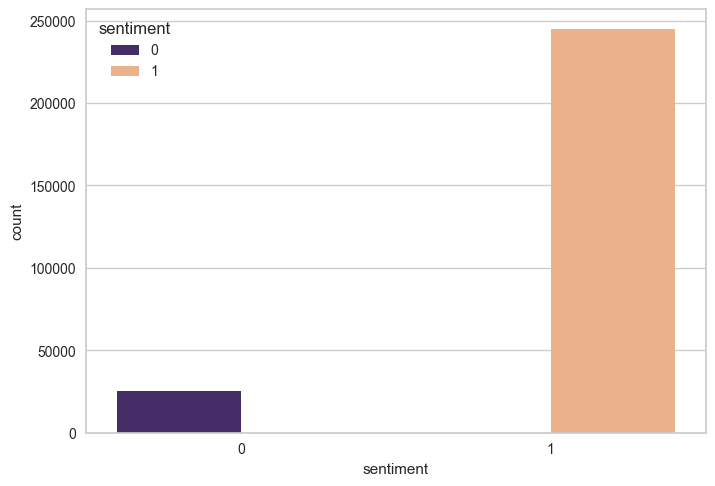

In [33]:
y_t = pd.DataFrame(y_train)

Bar_chart = sns.countplot(data=y_t, x='sentiment', hue="sentiment", palette=['#432371',"#FAAE7B"])
Bar_chart.set_xticklabels(Bar_chart.get_xticklabels());

-----

## Logistic Regression Pipeline

In [34]:
logistic_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())  
])

# Model selection (Grid Search CV)

## Hyperparameter Tuning
## This cell takes some time to run, so uncomment when ready

In [35]:
# %%time

# parameters = [
#     {
#         "vect__max_df": (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 20000, 40000, 60000, 80000, 100000),
#         'vect__min_df': (10, 20, 30, 40, 50),
#         "vect__ngram_range": ((1,1), (1,2), (1,3)), # unigrams or bigrams or trigrams
#         'tfidf__use_idf': (True, False),
#         'tfidf__norm': ('l1', 'l2', None),  
#         'classifier__solver' : ['sag'],
#         'classifier__penalty' : ['l2'],
#         'classifier__max_iter' : [1000],
#         'classifier__C' : np.logspace(-4, 4, 50),
#         'classifier__class_weight': ['balanced', None]
#     },
#     { 
#         "vect__max_df": (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 20000, 40000, 60000, 80000, 100000),
#         'vect__min_df': (10, 20, 30, 40, 50),
#         "vect__ngram_range": ((1,1), (1,2), (1,3)), # unigrams or bigrams or trigrams
#         'tfidf__use_idf': (True, False),
#         'tfidf__norm': ('l1', 'l2', None),  
#         'classifier__solver' : ['liblinear'],
#         'classifier__penalty' : ['l2','l1'],
#         'classifier__max_iter' : [1000],
#         'classifier__C' : np.logspace(-4, 4, 50),
#         'classifier__class_weight': ['balanced', None]
#     },
# ]

# cv = StratifiedKFold(n_splits=10)

# grid_search_tune = GridSearchCV(logistic_pipeline, parameters, cv=cv, n_jobs=-1, verbose=3, error_score='raise', scoring='f1')
# grid_search_tune.fit(X_train, y_train)

# print("Best parameters set:")
# print(grid_search_tune.best_estimator_)

To save time, I did not test Newton's method as a solver due to the computationally expensive use of the Hessian Matrix. With more time, I would also explore the 'saga' solver, which tends to work well on large datasets (similar to sag).

Below are our best hyperparameters:

{'classifier__C': 5.428675439323859,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'classifier__solver': 'sag'}
 
 We also want to use an ngram_range of (1,2) and keep the default on max_features, min_df, and max_df.

# Train Best Hyperparameters on Logistic Regression Model

In [36]:
lr_model = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2), max_features=None)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(C=5.428675439323859, max_iter=10000, random_state=42, penalty='l2', solver='sag', class_weight=None, n_jobs=-1))  
])

In [37]:
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [38]:
scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='accuracy', error_score="raise", n_jobs=-1)
print("Training Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training Accuracy: 0.97 (+/- 0.00)


In [ ]:
scores = cross_val_score(lr_model, X_test, y_test, cv=cv, scoring='accuracy', error_score="raise", n_jobs=-1)
print("Testing Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='f1', error_score="raise", n_jobs=-1)
print("Training F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores = cross_val_score(lr_model, X_test, y_test, cv=cv, scoring='f1', error_score="raise", n_jobs=-1)
print("Testing F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='f1_micro', error_score="raise", n_jobs=-1)
print("Training F1 Micro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores = cross_val_score(lr_model, X_test, y_test, cv=cv, scoring='f1_micro', error_score="raise", n_jobs=-1)
print("Testing F1 Micro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Evaluation Metrics: Best Logistic Regression Model

### Brief Evaluation Metrics

In [39]:
print("F1:", f1_score(y_test, y_pred, average='binary'))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print('-------------------------')
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

F1: 0.9830241909332641
Matthews Correlation Coefficient: 0.805180522031251
-------------------------
Accuracy: 0.9689455731870088
Precision: 0.9747741084922344
Recall: 0.9914151159368153
ROC AUC: 0.8707075579684076


### Classification Report

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6276
           1       0.97      0.99      0.98     61154

    accuracy                           0.97     67430
   macro avg       0.94      0.87      0.90     67430
weighted avg       0.97      0.97      0.97     67430



### Confusion Matrix

In [41]:
# Confusion Matrix
cf = confusion_matrix(y_test, y_pred)
cf

array([[ 4707,  1569],
       [  525, 60629]])

                            Logistic Regression                


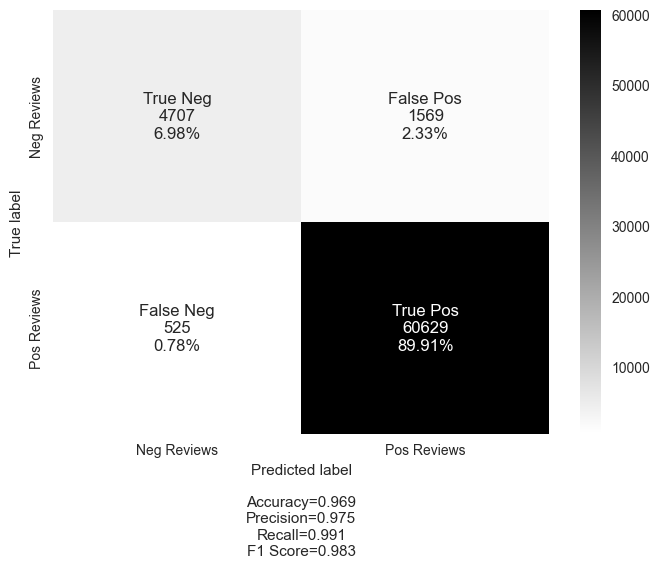

In [42]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neg Reviews', 'Pos Reviews']

print("                            Logistic Regression                ")

make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

### ROC Curves

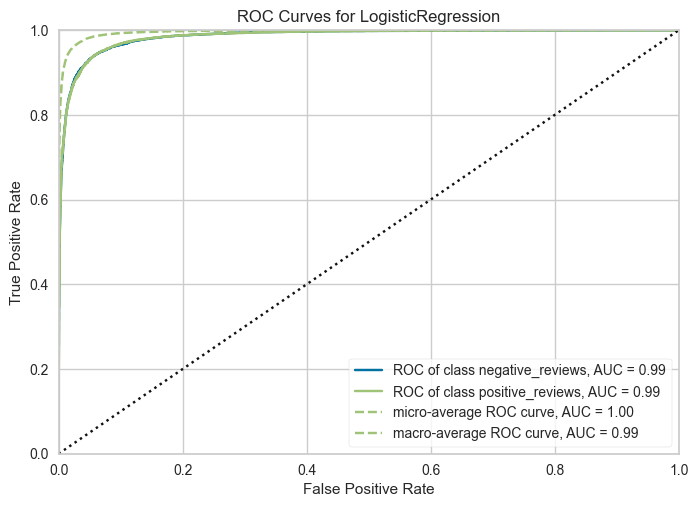

In [43]:
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(lr_model, classes=["negative_reviews", "positive_reviews"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

### Precision/Recall Plot

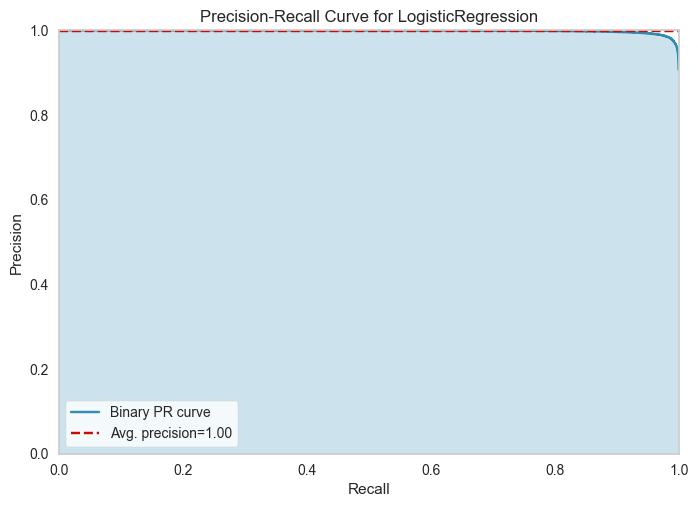

In [44]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(lr_model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

### Class Prediction Error

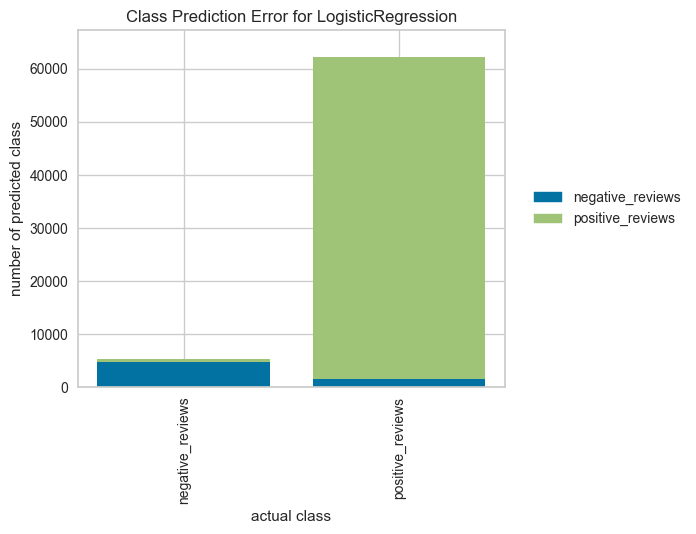

In [45]:
classes = ["negative_reviews", "positive_reviews"]

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    lr_model, classes=classes
)

# Fit the training data to the visualizer
# X_train = vectorizer.fit_transform(X_train)
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

# Feature Importance

Let's see what words/text are contributing to our model's prediction success/failure.

In [46]:
importance = lr_model.named_steps['classifier'].coef_
importance = np.sort(importance)
importance = importance.flatten()
importance

array([-19.85287965, -19.43914139, -18.2134201 , ...,  17.22011304,
        17.25152619,  17.42133345])

In [47]:
tfidf_mapping = lr_model.get_params()['vect'].vocabulary_
tfidf_map = [(x, tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_mapping

{'masterpiece': 2317199,
 'kite': 2045503,
 'runner': 3197663,
 'life': 2136734,
 'changing': 582170,
 'book': 422864,
 'read': 2995330,
 'including': 1863500,
 'catcher': 557796,
 'rye': 3202128,
 'paint': 2682287,
 'story': 3555347,
 'afghanamerican': 74298,
 'man': 2288630,
 'many': 2298606,
 'struggle': 3587922,
 'mixture': 2408064,
 'multiple': 2459194,
 'theme': 3741067,
 'lesson': 2121367,
 'molded': 2412208,
 'painted': 2682794,
 'constructed': 753493,
 'master': 2315845,
 'piece': 2775780,
 'teach': 3694651,
 'lived': 2194533,
 'decide': 891317,
 'live': 2192033,
 'masterpiece kite': 2317585,
 'kite runner': 2045648,
 'runner life': 3198003,
 'life changing': 2137860,
 'changing book': 582230,
 'book read': 436240,
 'read including': 3000155,
 'including catcher': 1863721,
 'catcher rye': 557845,
 'rye kite': 3202212,
 'runner paint': 3198069,
 'paint story': 2682689,
 'story afghanamerican': 3555549,
 'afghanamerican man': 74305,
 'man many': 2290362,
 'many struggle': 230208

In [48]:
coef_df = pd.DataFrame(list(zip(tfidf_map, importance)), columns=['word', 'coef'])
coef_df = coef_df.sort_values(by='coef', ascending=False)
coef_df[['word', 'occurance']] = pd.DataFrame(coef_df['word'].tolist(), index=coef_df.index)
coef_df['word'] = coef_df['word'].astype(str)
coef_df['coef']
coef_df.tail()

,word,coef,occurance
4,changing,-14.842419,582170
3,life,-17.145483,2136734
2,runner,-18.213420,3197663
1,kite,-19.439141,2045503
0,masterpiece,-19.852880,2317199


In [49]:
coef_list = list(zip(coef_df['word'], importance))
coef_dict={x[0]: x[1] for x in coef_list}

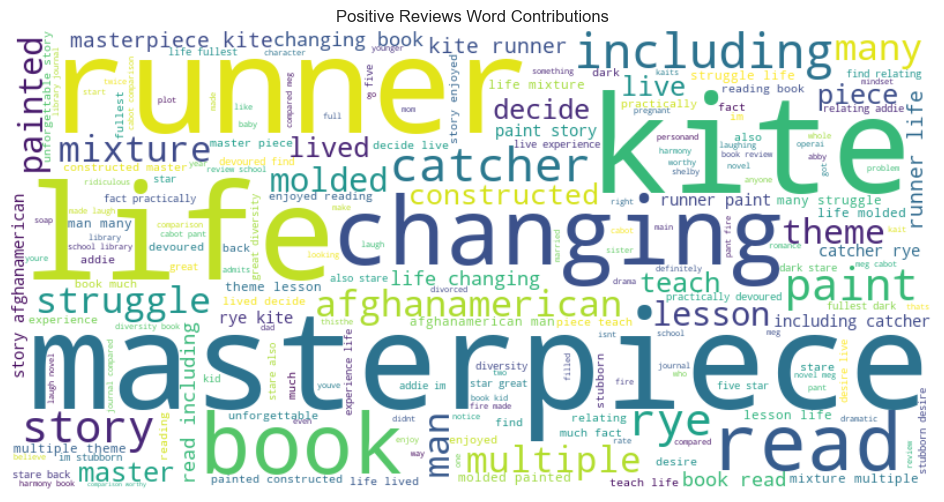

In [50]:
# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(coef_dict)

# Plot word cloud for features contributing to a positive review classification
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Contributions')
plt.axis('off')
plt.show()

### Let's dig in more into with a graph instead of a WorldCloud to see what words are contributing most to our model's performance.

In [51]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'positive_reviews':tops,
            'negative_reviews':bottom
        }
    return classes


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 20))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Reviews', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Reviews', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [52]:
importance_tfidf = get_most_important_features(lr_model.named_steps['vect'], lr_model.named_steps['classifier'], 70)


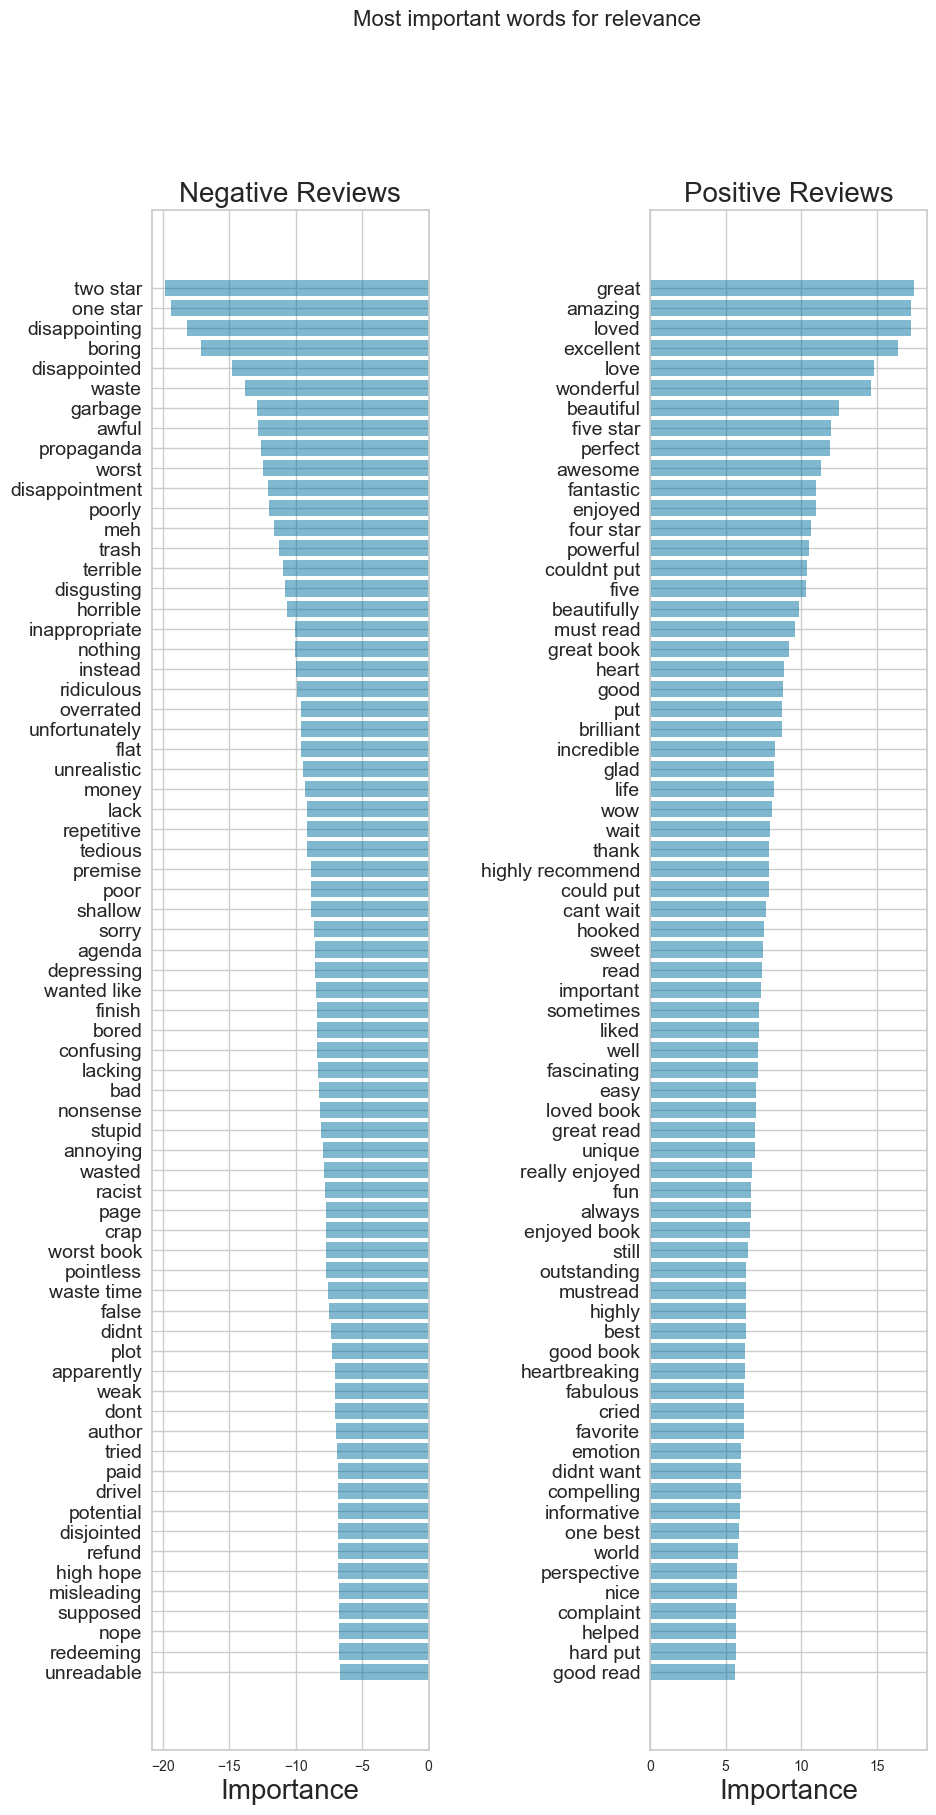

In [53]:
top_scores = [a[0] for a in importance_tfidf[0]['positive_reviews']]
top_words = [a[1] for a in importance_tfidf[0]['positive_reviews']]
bottom_scores = [a[0] for a in importance_tfidf[0]['negative_reviews']]
bottom_words = [a[1] for a in importance_tfidf[0]['negative_reviews']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Out of interest, let's take a look at a word correlation plot, and see if there are correlations between words in the corpus.

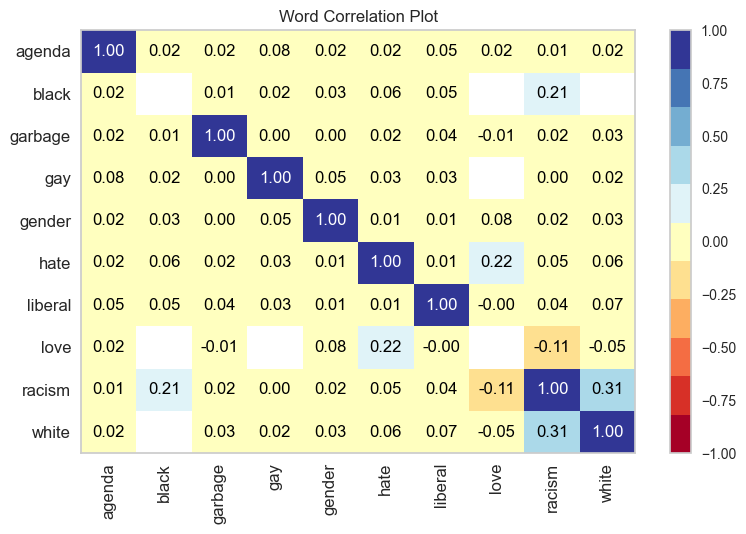

In [54]:
# You can add words here to see how they may correlate in other documents
words = ['gender', 'racism', 'white', 'black', 'gay', 'liberal', 'agenda', 'garbage', 'love', 'hate']

# Instantiate the visualizer and draw the plot
viz = WordCorrelationPlot(words)
viz.fit(df.pre_process)
viz.show();

# Failure/Error Analysis

Let's manually take a look at the predictions and actual scores to see how well our model is doing.

In [55]:
sample_prediction = y_pred[:20]

for (sample, pred) in zip(X_test, sample_prediction):
    print(sample, "Prediction=> ", pred)
    print('-----------------')

bridge terabithia review loved bridge terabithia small town socially invisible boy friendship change life lark creek setting story backward town virginia people like change frown difference hardworking struggling people whatever little problematic jesse aaron artistically talented creative boy fit child town like watching television sitting home relaxing difference child jesse tend friend change strange new girl leslie move town beat jesse race recess like jesse leslie outcast television prefers outside jesse befriend ultimately change life became close determined needed place escape lonely life noticed creek rope swing hanging decided could create world side creek travelled rope many adventure incident occurred jesse becomes depressed separated everyone push back reality becomes harsh everyone around bitterness climax harming little sister may belle make become close itthis story truly one favorite style writing honest dialogue make understandable likeable story although story sad tim

In [56]:
actual_rating = y_test[:20]

for (sample, actual) in zip(X_test, actual_rating):
    print(sample, "Actual=> ", actual)
    print('-----------------')

bridge terabithia review loved bridge terabithia small town socially invisible boy friendship change life lark creek setting story backward town virginia people like change frown difference hardworking struggling people whatever little problematic jesse aaron artistically talented creative boy fit child town like watching television sitting home relaxing difference child jesse tend friend change strange new girl leslie move town beat jesse race recess like jesse leslie outcast television prefers outside jesse befriend ultimately change life became close determined needed place escape lonely life noticed creek rope swing hanging decided could create world side creek travelled rope many adventure incident occurred jesse becomes depressed separated everyone push back reality becomes harsh everyone around bitterness climax harming little sister may belle make become close itthis story truly one favorite style writing honest dialogue make understandable likeable story although story sad tim

We did a good job with our predictions here. Let's take a look at our confusion matrix again, and see where our predictions failed.

                         Logistic Regression                


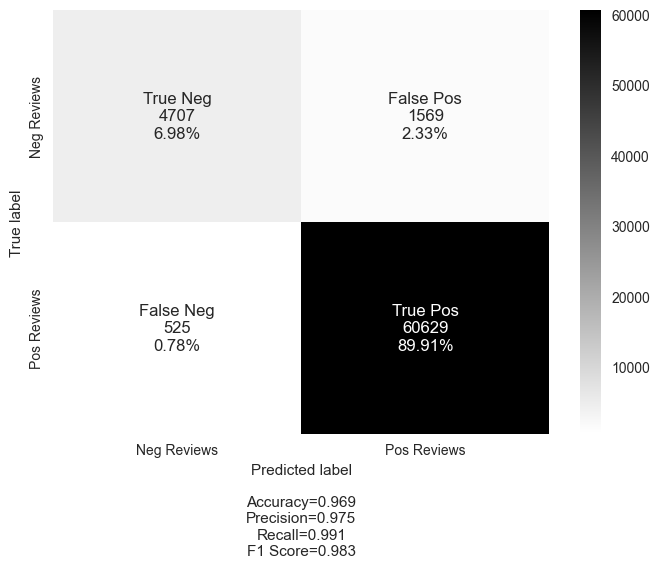

In [57]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neg Reviews', 'Pos Reviews']

print("                         Logistic Regression                ")

make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

### Let's take a look at text that we **predicted would be positive, but the text was actually negative**, aka our **False Positives**. 

In [58]:
false_positive_text = X_test[(y_pred==1) & (y_test==0)]

In [59]:
for i in false_positive_text:
    print(i)
    print('                                                        ')
    print('Prediction --> 1 (positive review)')
    print('Actual --> 0 (negative review)')
    print('                                                        ')
    print('                                                        ')
    print('                                                        ')

perpetuating stereotype talk race racism see well go
                                                        
Prediction --> 1 (positive review)
Actual --> 0 (negative review)
                                                        
                                                        
                                                        
never grabbed reading kindle made called quits number page reading folk clean teeth gave enlightenment isnt maybe story unfolds something amazing book give clue upcoming amazing reading well book kindle know start hitting next page next page next page im checking enjoy im sure great
                                                        
Prediction --> 1 (positive review)
Actual --> 0 (negative review)
                                                        
                                                        
                                                        
oh lordy book considered classic daughter recommended found bit cumbersome 

### Insights: 

- One reason for possible prediction failure with these false positives is that many of the positive reviews will have words indicating how difficult, disturbing, overwhelming, violent, etc. a banned book's subject matter may be, but the reviewer had positive text/ratings/things to say about the book overall. 


- Additionally, Amazon.com reviewers will sometimes write what seems like a positive review, but they will give the book a negative rating, and vice versa.

Let's take a look at text that we **predicted would be negative, but the text was actually positive**, aka our **False Negatives**. 

In [60]:
false_negative_text = X_test[(y_pred==0) & (y_test==1)]

In [61]:
for i in false_negative_text:
    print(i)
    print('                                                        ')
    print('Prediction --> 0 (negative review)')
    print('Actual --> 1 (positive review)')
    print('                                                        ')
    print('                                                        ')
    print('                                                        ')

contrived ending would agree reviewer troubled ending word contrived sense many amys action planned advance uncanny result seem realistic hand book planned written author amy author writeri guess could plotted year long time framemaybe unbalanced mind psychopathas reflect line thought maybe ultimate horror bookand case maybe ending although appearing contrived brutal nightmare two protagonist
                                                        
Prediction --> 0 (negative review)
Actual --> 1 (positive review)
                                                        
                                                        
                                                        
make three chapter youre home free slaughterhouse five ive heard name throughout year never read enjoy science fiction clearly novel regularly list best science fiction book timeswhat thought found difficult follow dont get wrong enjoy timeline convoluted reason important story keeping everything place time r

### Insights: 

- One reason for possible prediction failure with these false negatives is that many of the negative reviews will have neutral to apathetic words like "meh," "disappointing," "so so," "was ok," etc., but many of these reviewers decided to give what seems like neutral/apathetic to critical/fairly negative reviews. Yet, the Amazon.com banned book reviewers will give the book a positive review. 


- With more time, it might be interesting to bring in an emotion lexicon like NRC Lexicon to see if we can label a word with some of the eight emotions (anger, anticipation, disgust, fear, joy, sadness, surprise, trust) and do a better job of predicting whether a review is negative or positive.

# Sensitivity Analysis 
## (C Hyperparameter)

Changing our `C` hyperparameter did not make much of an impact.

In [65]:
training_accuracy = []
test_accuracy = []

c_settings = np.logspace(-4, 4, 50)

# Evaluate the training and test classification errors for each value of C
for i in c_settings:
 
    # Create LogisticRegression object and fit
    lr_model.fit(X_train, y_train)
    # Evaluate error rates and append to lists
    training_accuracy.append(lr_model.score(X_train, y_train))
    
    test_accuracy.append(lr_model.score(X_test, y_test))

# Plot results
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.legend(("Training Accuracy", "Test Accuracy"))
plt.ylabel('Accuracy Score')
plt.xlabel('C (Inverse regularization strength)')
plt.show()

Picking the right `ngram_range` made some contributions to creating a better model. In fact, tuning the vectorizer made the most impact on the model's performance. Also, changing the features/text has an impact on the model's performance.

In [ ]:
# train model with different n-gram ranges
for N in range(1,6):
    
    # convert training data to bag of words
    cv = CountVectorizer(analyzer='word', ngram_range=(1,N), stop_words='english')
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    
    # train model and generate predictions
    clf = LogisticRegression(C=5.428675439323859, max_iter=10000, random_state=42, penalty='l2', solver='sag', class_weight=None, n_jobs=-1)
    clf.fit(X_train_cv, y_train)
    y_pred = clf.predict(X_test_cv)
    
    # compute f-1 score
    score = np.round(f1_score(y_test, y_pred, average='weighted'), 4)
    print('F-1 score of model with n-gram range of {}: {}'.format((1, N), score))

Here we see that n-gram(1,2) and n-gram(1,3) work best. Working with larger n-gram features may bring optimal results, but it could hamper model performance due to sparse features, especially on negative reviews. Let's check out `max_features` on our vectorizer.

In [ ]:
from sklearn.metrics import f1_score

max_feat = [None, 60000, 80000, 100000, 120000]

# train model with different n-gram ranges
for i in max_feat:
    
    # convert training data to bag of words
    cv = CountVectorizer(analyzer='word', ngram_range=(1,2), max_features=i)
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    
    # train model and generate predictions
    clf = LogisticRegression(C=5.428675439323859, max_iter=10000, random_state=42, penalty='l2', solver='sag', class_weight=None, n_jobs=-1)
    clf.fit(X_train_cv, y_train)
    y_pred = clf.predict(X_test_cv)
    
    # compute f-1 score
    score = np.round(f1_score(y_test, y_pred, average='weighted'),4)
    print('F-1 score of model with max features of {}: {}'.format(i, score))

Keeping `max_features` at `None` seems to work best.

## Learning Curves

Let's plot a learning curve to diagnose any bias-variance in our best Logistic Regression model: lr_model.

In [67]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_model, X=X_train, y=y_train,
                                                       cv=cv, train_sizes=np.linspace(0.1, 1.0, 10, 100), n_jobs=-1)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
# Plot the learning curve
plt.figure(figsize=(10,10)) 
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Cross-validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
# plt.ylim(bottom=0)
# plt.xlim(left=0)
plt.grid()
plt.legend(loc='lower right')
plt.show()

Figure: Learning curve representing training and validation scores vs training data size

### **Learning Curve Insights**

- As the training size grows, the difference between the training and cross-validation accuracy gets smaller. Generally, at the best point, there is about a 2% difference in accuracy between  training accuracy and cross-validation accuracy.


- As the training size is smaller, the difference between the training and cross-validation accuracy gets larger, indicating some overfitting, or higher variance, (especially before the training data size of ~50,000), although there is not too large a difference in terms of accuracy. We could add more data to see if we could reach a closer model accruracy between the training accuracy and cross-validation accuracy.